In [ ]:
import numpy as np
import pandas as pd

import scanpy as sc
import json
from skimage import io
import matplotlib.pyplot as plt
import math

import h5py
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap, Normalize

In [279]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
def regen_grid(tissue_position: pd.DataFrame, scale_factor: float = 4,size_factor:float = 40) -> pd.DataFrame:
    """
    Transforms tissue position coordinates using an affine transformation.
    
    Parameters:
        tissue_position (pd.DataFrame): DataFrame containing 'spot_x' and 'spot_y' columns.
        scale_factor (float): Scaling factor for transformation.
    
    Returns:
        pd.DataFrame: Transformed DataFrame with 'pxl_x', 'pxl_y', 'tl_pxl_x', and 'tl_pxl_y' columns.
    """
    x_offset = 1/2 * scale_factor  # Pixel center offset
    #y_offset = (tissue_position['spot_y'].max()+1)* scale_factor - 1/2*scale_factor
    y_offset = size_factor - 1/2*scale_factor
    affine_mtx = np.array([
        [scale_factor, 0, x_offset],
        [0, -scale_factor, y_offset]
    ])
    # print(affine_mtx )
    coords = tissue_position[['spot_x', 'spot_y']].values
    coords_homo = np.hstack([coords, np.ones((coords.shape[0], 1))])  # Homogeneous coordinates
    
    trans_coords = (affine_mtx @ coords_homo.T).T  # Apply affine transformation
    tissue_position[['pxl_x', 'pxl_y']] = trans_coords
    
    scale_length = scale_factor
    tissue_position['tl_pxl_x'] = tissue_position['pxl_x'] - scale_length / 2
    tissue_position['tl_pxl_y'] = tissue_position['pxl_y'] - scale_length / 2
    
    return tissue_position


def _calc_corner_coord(df):
    cx, cy = df['spot_x'].to_numpy(), df['spot_y'].to_numpy() # center point

    dx = np.array([-0.5, -0.5, 0.5, 0.5])
    dy = np.array([-0.5, 0.5, -0.5, 0.5])
    
    corner_cx = cx[:, None] + dx # tl
    corner_cy = cy[:, None] + dy
    
    return corner_cx, corner_cy

def _trans_coord(cx_corners, cy_corners, z=0, spot_to_microscope=None):

    z_array = np.full(cx_corners.shape, z)
    corners_stack = np.stack((cx_corners, cy_corners, z_array), axis=-1)

    transformed = np.dot(corners_stack, spot_to_microscope.T)
    
    px_fr = transformed[..., 0] / transformed[..., 2]
    py_fr = transformed[..., 1] / transformed[..., 2]
    pz = transformed[..., 2]
    return px_fr, py_fr, pz

def process_dataframe(df, spot_to_microscope):
    cx_corners, cy_corners = _calc_corner_coord(df)
    px_fr, py_fr, pz = _trans_coord(cx_corners, cy_corners, z=1, spot_to_microscope=spot_to_microscope)
    df['corner_1_px_fr'], df['corner_1_py_fr'] = px_fr[:, 0], py_fr[:, 0]
    df['corner_2_px_fr'], df['corner_2_py_fr'] = px_fr[:, 1], py_fr[:, 1]
    df['corner_3_px_fr'], df['corner_3_py_fr'] = px_fr[:, 2], py_fr[:, 2]
    df['corner_4_px_fr'], df['corner_4_py_fr'] = px_fr[:, 3], py_fr[:, 3]
    
    return df



def get_patch(img,x_start,x_end,y_start,y_end):
    patch = img[y_start:y_end, x_start:x_end]
    return patch


def extract_patch(HD_grid, HE, HVG_adata, x_hd, y_hd, patch_size, scale_factor):
    # Selecting the patch in HD grid
    # center coord
    patch_HD = HD_grid[(HD_grid["spot_x"] >= x_hd) & (HD_grid["spot_x"] < x_hd + patch_size) & 
                   (HD_grid["spot_y"] >= y_hd) & (HD_grid["spot_y"] < y_hd + patch_size)].copy()

    # Calculating the start and end positions for the HE patch
    x_start = math.ceil(patch_HD["tl_pxl_x"].min()) # 3-18 向右取整数
    x_end = math.ceil(patch_HD["tl_pxl_x"].max() + scale_factor)
    y_start = math.ceil(patch_HD["tl_pxl_y"].min())
    y_end = math.ceil(patch_HD["tl_pxl_y"].max() + scale_factor)

    # Extracting the patch from the HE image
    patch_HE = get_patch(HE, x_start, x_end, y_start, y_end)
    
    # Getting the subset of gene expression data
    ## Even in raw, there still be some sequencing block does not contain any counts?
    adata_subset = HVG_adata[patch_HD.index].copy()

    # Recording the correspondence from HE to HD in in-patch coordinates
    patch_HD['in_patch_pxl_cx'] = patch_HD['pxl_x'] - patch_HD['pxl_x'].min() + 0.5 * (scale_factor - 1)
    patch_HD['in_patch_pxl_cy'] = patch_HD['pxl_y'] - patch_HD['pxl_y'].min() + 0.5 * (scale_factor - 1)
    
    # For the construction of the original LR gene_fg
    # np.filp
    patch_HD['spot_x_in_patch'] = patch_HD['spot_x'] - patch_HD['spot_x'].min()
    patch_HD['spot_y_in_patch'] = patch_HD['spot_y'] - patch_HD['spot_y'].min()
    
    patch_HD.loc[:, 'in_patch_tlx'] = patch_HD['tl_pxl_x'] - patch_HD['tl_pxl_x'].min()#+scale_factor #-0.5  #3-13
    patch_HD.loc[:, 'in_patch_tly'] = patch_HD['tl_pxl_y'] - patch_HD['tl_pxl_y'].min()#+scale_factor#-0.5  #3-13
    
    max_y = patch_HD['spot_y_in_patch'].max()
    patch_HD['spot_y_in_patch'] = max_y - patch_HD['spot_y_in_patch']

    return patch_HE, adata_subset, patch_HD

def plot_patch(ax, patch_HE, adata_subset, patch_HD, scale_factor, gene='Total Counts'):
    # Get gene expression values
    gene_expression = adata_subset.obs_vector(gene)

    # Define color map
    cmap = LinearSegmentedColormap.from_list("custom_red", [(1, 1, 1, 0), (1, 0, 0, 1)], N=8192)
    norm = Normalize(vmin=gene_expression.min(), vmax=gene_expression.max())

    # Plot background image
    ax.imshow(patch_HE)

    # Draw gene expression patches
    for (index, row), expr in zip(patch_HD.iterrows(), gene_expression):
        color = cmap(norm(expr)) if expr > 0 else (1, 1, 1, 0)  # Fully transparent for zero expression
        rect = patches.Rectangle(
            (row['in_patch_tlx'] - 0.5, row['in_patch_tly'] - 0.5), 
            scale_factor, scale_factor,
            linewidth=1, edgecolor='blue', linestyle='--', 
            facecolor=color, #alpha=1 if expr > 0 else 0  # Ensure transparency for zero expression
        )
        ax.add_patch(rect)

    # Set title
    # ax.set_title(f'{gene} localization', fontsize=16, color='r')

    # Add colorbar (specific to this axis)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    # cbar.set_label('Expression Level')
    ax.set_xticks([])  # 移除 X 轴刻度
    ax.set_yticks([])  # 移除 Y 轴刻度
    ax.tick_params(left=False, bottom=False)  # 隐藏刻度标记
    return ax


def plot_patch_with_cropped_HE(ax, HE_img, selected_ROI, adata_subset, gene='Total Counts'):
    """
    Crop H&E image based on the ROI and plot all polygon patches.
    Colored fill indicates gene expression; empty outline for zero expression.

    Parameters:
    - ax: Matplotlib axis where the image and patches will be plotted.
    - HE_img: Full H&E image (numpy array).
    - selected_ROI: DataFrame with polygon corner coordinates (corner_*_px_fr, corner_*_py_fr).
    - adata_subset: AnnData subset aligned with selected_ROI.
    - gene: The gene to visualize.
    """

    # 获取角点坐标列
    x_cols = [col for col in selected_ROI.columns if '_px_fr' in col]
    y_cols = [col for col in selected_ROI.columns if '_py_fr' in col]
    all_x = selected_ROI[x_cols].values.flatten()
    all_y = selected_ROI[y_cols].values.flatten()

    # 计算裁剪区域
    x_min, x_max = int(all_x.min()), int(all_x.max())
    y_min, y_max = int(all_y.min()), int(all_y.max())
    cropped_HE_img = HE_img[y_min:y_max, x_min:x_max]

    # 获取表达数据
    gene_expression = adata_subset.obs_vector(gene)

    # 定义色图
    cmap = LinearSegmentedColormap.from_list("custom_red", [(1, 1, 1, 0), (1, 0, 0, 1)], N=8192)
    norm = Normalize(vmin=gene_expression.min(), vmax=gene_expression.max())

    # 画底图
    ax.imshow(cropped_HE_img)

    # 遍历每个 patch，多边形绘制
    for (index, row), expr in zip(selected_ROI.iterrows(), gene_expression):
        polygon_coords = [
            (row['corner_1_px_fr'] - x_min, row['corner_1_py_fr'] - y_min),
            (row['corner_2_px_fr'] - x_min, row['corner_2_py_fr'] - y_min),
            (row['corner_4_px_fr'] - x_min, row['corner_4_py_fr'] - y_min),
            (row['corner_3_px_fr'] - x_min, row['corner_3_py_fr'] - y_min),
        ]
        if expr > 0:
            color = cmap(norm(expr))
            poly = Polygon(polygon_coords, closed=True, facecolor=color, edgecolor='blue', linewidth=1)
        else:
            # 无表达，仅画边框（浅灰）
            poly = Polygon(polygon_coords, closed=True, facecolor=(1,1,1,0), edgecolor='blue', linewidth=1)
        poly.set_linestyle('dashed')
        ax.add_patch(poly)

    # 标题 & 色条
    # ax.set_title(f'{gene} expression (polygon patch)', fontsize=16, color='r')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    # cbar.set_label('Expression Level')
    ax.set_xticks([])  # 移除 X 轴刻度
    ax.set_yticks([])  # 移除 Y 轴刻度
    ax.tick_params(left=False, bottom=False)  # 隐藏刻度标记

    return ax

In [281]:
# draw the region at 0.5mpp
img_05_path = '/home/zongxu/STORM/texturemapping_check/test/he-fnl_05.tiff'
HE_05 = io.imread(img_05_path)

img_1_path = '/home/zongxu/STORM/texturemapping_check/test/he-fnl_1.tiff'
HE_1 = io.imread(img_1_path)

img_2_path = '/home/zongxu/STORM/texturemapping_check/test/he-fnl_2.tiff'
HE_2 = io.imread(img_2_path)

tpl_path = '/data200T/STORM/10X_HD_new/CC_P1/binned_outputs/square_002um/spatial/tissue_positions.parquet'

In [282]:
# load transcriptomics
path = '/data200T/STORM/10X_HD_new/CC_P1/binned_outputs/square_002um/raw_feature_bc_matrix.h5'
adata = sc.read_10x_h5(path)
# path = '/data200T/SPACseq/HD/output/subq/outs/binned_outputs/square_008um/combined.h5ad'
# adata = sc.read_h5ad(path)
adata.var_names_make_unique()

/home/zongxu/miniconda3/envs/spatialCC/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/zongxu/miniconda3/envs/spatialCC/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [283]:
# Load tissue positions from the Parquet file
tissue_position = pd.read_parquet(tpl_path)
# Set the index of the DataFrame to be the barcode column
tissue_position.set_index('barcode', inplace=True)
# Rename columns to match x and y coordinate of each data modality
tissue_position = tissue_position.rename(columns={
    'array_row': 'spot_y',
    'array_col': 'spot_x',
    'pxl_row_in_fullres': 'pxl_y_in_fullres',
    'pxl_col_in_fullres': 'pxl_x_hires'
})
tissue_position = tissue_position[['spot_x', 'spot_y', 'in_tissue']].copy()

#### 0.5mpp

In [284]:
size_factor_05 = HE_05.shape[0]
scale_factor_05 = 4
HD_grid_05 = regen_grid(tissue_position,
                        scale_factor_05,
                        size_factor_05)

In [285]:
#### Region
# 0.5mpp, scale_factor=4 for bin2um
region_size_05 = 112

# calculate HD spot to H&E (0.5um)
# correspondance and HD units in H&E coordinates.
# (height, width, channels) -> (y, x, c)
y_min_05 = 4800 # 4700 5850
y_max_05 = y_min_05 + region_size_05
x_min_05 = 5850
x_max_05 = x_min_05 + region_size_05

x_hd_05, y_hd_05 = x_min_05//scale_factor_05, y_min_05//scale_factor_05
patch_size_05 = int(region_size_05/2)

patch_HE_05, adata_subset_05, patch_HD_05 = extract_patch(HD_grid_05, HE_05,
                                                          adata, x_hd_05, y_hd_05,
                                                          patch_size_05, scale_factor_05)

adata_subset_05 = adata_subset_05[:, ~adata_subset_05.var_names.str.startswith('MT-')].copy()
#sc.pl.highest_expr_genes(adata_subset_05, n_top=10)

In [286]:
plt.imshow(patch_HE_05)
plt.axis('off') 
plt.savefig(f'./fig/binX_{x_hd_05}_binY_{y_hd_05}_224_tile_HE_05um.pdf', bbox_inches='tight')
plt.close()

In [287]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7))
plot_patch(axs, patch_HE_05, adata_subset_05, patch_HD_05,
           scale_factor_05, gene='MUC2')
plt.savefig(f'./fig/binX_{x_hd_05}_binY_{y_hd_05}_224_MUC2_HE_05um.pdf', format='pdf', bbox_inches='tight')
plt.close()

In [288]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7))
plot_patch(axs, patch_HE_05, adata_subset_05, patch_HD_05,
           scale_factor_05, gene='IGHG1')
plt.savefig(f'./fig/binX_{x_hd_05}_binY_{y_hd_05}_224_IGHG1_HE_05um.pdf', format='pdf', bbox_inches='tight')
plt.close()

In [289]:
# GET THE DAMN CELL

In [290]:
x_hd_05_CELL, y_hd_05_CELL = 1508, 1205
patch_size_05_CELL = 8
# 01207_01507
patch_HE_05_CELL, adata_subset_05_CELL, patch_HD_05_CELL = extract_patch(HD_grid_05, HE_05,
                                                          adata, x_hd_05_CELL, y_hd_05_CELL,
                                                          patch_size_05_CELL, scale_factor_05)

In [333]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7))
plot_patch(axs, patch_HE_05_CELL, adata_subset_05_CELL, patch_HD_05_CELL,
           scale_factor_05, gene='CD8A')
plt.savefig(f'./fig/binX_{x_hd_05_CELL}_binY_{y_hd_05_CELL}_224_IGHG1_CEL_HE_05um.pdf', format='pdf', bbox_inches='tight')
plt.close()

#### 1 mpp

In [292]:
size_factor_1 = HE_1.shape[0]
scale_factor_1 = 2
HD_grid_1 = regen_grid(tissue_position,
                        scale_factor_1,
                        size_factor_1)

In [293]:
# draw the region at 1mpp
# 1mpp, scale_factor=2 for bin2um
size_factor = scale_factor_05/scale_factor_1
region_size_1 = region_size_05 / size_factor

# correspondance and HD units in H&E coordinates.
# (height, width, channels) -> (y, x, c)
y_min_1 = y_min_05 / size_factor
y_max_1 = y_min_1 + region_size_1
x_min_1 = x_min_05 / size_factor
x_max_1 = x_min_1 + region_size_1

x_hd_1, y_hd_1 = x_min_1//scale_factor_1, y_min_1//scale_factor_1
# patch_size_1 = int(region_size_1/2)
patch_size_1 = patch_size_05
patch_HE_1, adata_subset_1, patch_HD_1 = extract_patch(HD_grid_1, HE_1,
                                                          adata, x_hd_1, y_hd_1,
                                                          patch_size_1, scale_factor_1)

In [294]:
plt.imshow(patch_HE_1)
plt.axis('off') 
plt.savefig(f'./fig/binX_{x_hd_1}_binY_{y_hd_1}_224_tile_HE_1um.pdf', bbox_inches='tight')
plt.close()

In [295]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7))
plot_patch(axs, patch_HE_1, adata_subset_1, patch_HD_1,
           scale_factor_1, gene='MUC2')
plt.savefig(f'./fig/binX_{x_hd_1}_binY_{y_hd_1}_224_MUC2_HE_1um.pdf', format='pdf', bbox_inches='tight')
plt.close()

In [296]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7))
plot_patch(axs, patch_HE_1, adata_subset_1, patch_HD_1,
           scale_factor_1, gene='IGHG1')
plt.savefig(f'./fig/binX_{x_hd_1}_binY_{y_hd_1}_224_IGHG1_HE_1um.pdf', format='pdf', bbox_inches='tight')
plt.close()

In [297]:
x_hd_1_CELL, y_hd_1_CELL = 1508, 1205
patch_size_1_CELL = 8
# 01207_01507
patch_HE_1_CELL, adata_subset_1_CELL, patch_HD_1_CELL = extract_patch(HD_grid_1, HE_1,
                                                          adata, x_hd_1_CELL, y_hd_1_CELL,
                                                          patch_size_1_CELL, scale_factor_1)

In [334]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7))
plot_patch(axs, patch_HE_1_CELL, adata_subset_1_CELL, patch_HD_1_CELL,
           scale_factor_1, gene='CD8A')
plt.savefig(f'./fig/binX_{x_hd_1_CELL}_binY_{y_hd_1_CELL}_224_IGHG1_CEL_HE_1um.pdf', format='pdf', bbox_inches='tight')
plt.close()

#### 2 mpp

In [299]:
size_factor_2 = HE_2.shape[0]
scale_factor_2 = 1
HD_grid_2 = regen_grid(tissue_position,
                        scale_factor_2,
                        size_factor_2)

In [300]:
size_factor = scale_factor_05 / scale_factor_2
region_size_2 = region_size_05 / size_factor


# (height, width, channels) -> (y, x, c)
y_min_2 = y_min_05 / size_factor
y_max_2 = y_min_2 + region_size_2
x_min_2 = x_min_05 / size_factor
x_max_2 = x_min_2 + region_size_2

x_hd_2, y_hd_2 = x_min_2//scale_factor_2, y_min_2//scale_factor_2
# patch_size_1 = int(region_size_1/2)
patch_size_2 = region_size_2
patch_HE_2, adata_subset_2, patch_HD_2 = extract_patch(HD_grid_2, HE_2,
                                                          adata, x_hd_2, y_hd_2,
                                                          patch_size_2*2, scale_factor_2)

In [301]:
plt.imshow(patch_HE_2)
plt.axis('off') 
plt.savefig(f'./fig/binX_{x_hd_2}_binY_{y_hd_2}_224_tile_HE_2um.pdf', bbox_inches='tight')
plt.close()

In [302]:
gene = 'MUC2'
fig, axs = plt.subplots(1, 1, figsize=(15, 7))
plot_patch(axs, patch_HE_2, adata_subset_2, patch_HD_2,
           scale_factor_2, gene=gene)
plt.savefig(f'./fig/binX_{x_hd_2}_binY_{y_hd_2}_224_{gene}_HE_2um.pdf', format='pdf', bbox_inches='tight')
plt.close()

In [303]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7))
plot_patch(axs, patch_HE_2, adata_subset_2, patch_HD_2,
           scale_factor_2, gene='IGHG1')
plt.savefig(f'./fig/binX_{x_hd_2}_binY_{y_hd_2}_224_IGHG1_HE_2um.pdf', format='pdf', bbox_inches='tight')
plt.close()

In [304]:
x_hd_2_CELL, y_hd_2_CELL = 1508, 1205
patch_size_2_CELL = 8
# 01207_01507
patch_HE_2_CELL, adata_subset_2_CELL, patch_HD_2_CELL = extract_patch(HD_grid_2, HE_2,
                                                          adata, x_hd_2_CELL, y_hd_2_CELL,
                                                          patch_size_2_CELL, scale_factor_2)

In [335]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7))
plot_patch(axs, patch_HE_2_CELL, adata_subset_2_CELL, patch_HD_2_CELL,
           scale_factor_2, gene='CD8A')
plt.savefig(f'./fig/binX_{x_hd_2_CELL}_binY_{y_hd_2_CELL}_224_IGHG1_CEL_HE_2um.pdf', format='pdf', bbox_inches='tight')
plt.close()

#### RAW!

In [306]:
raw_img = '/data200T/STORM/10X_HD_new/CC_P1/Visium_HD_Human_Colon_Cancer_P1_tissue_image.btf'
HE_img = io.imread(raw_img)

slice_path = '/data200T/STORM/10X_HD_new/CC_P1/Visium_HD_Human_Colon_Cancer_P1_feature_slice.h5'

with h5py.File(slice_path, 'r') as file:
    metadata_json = file.attrs['metadata_json']
metadata = json.loads(metadata_json)
spot_to_microscope = np.array(metadata['transform_matrices']['spot_colrow_to_microscope_colrow'])

In [307]:
raw_patch = process_dataframe(tissue_position, spot_to_microscope)

In [308]:
selected_ROI = raw_patch[raw_patch.index.isin(adata_subset_05.obs.index)]

In [309]:
x_cols = [col for col in selected_ROI.columns if '_px_fr' in col]
y_cols = [col for col in selected_ROI.columns if '_py_fr' in col]

all_x = selected_ROI[x_cols].values.flatten()
all_y = selected_ROI[y_cols].values.flatten()

x_max = all_x.max()
x_min = all_x.min()
y_max = all_y.max()
y_min = all_y.min()

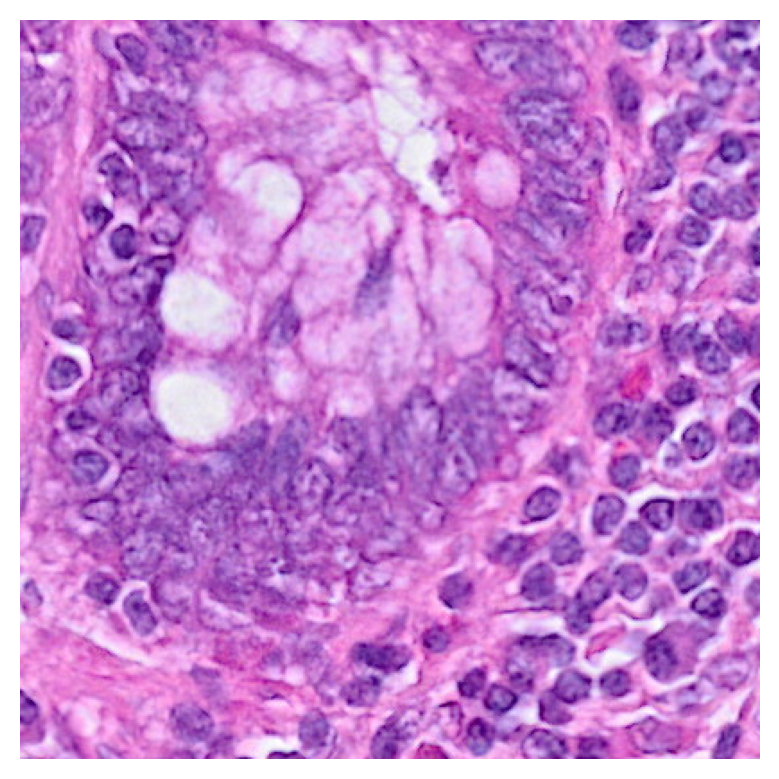

In [310]:
plt.imshow(HE_img[int(y_min):int(y_max), int(x_min):int(x_max)])
plt.axis('off') 
plt.savefig(f'binX_{x_hd_05}_binY_{y_hd_05}_224_tile_HE_raw.pdf', bbox_inches='tight')
plt.show()

In [311]:
from matplotlib.patches import Polygon

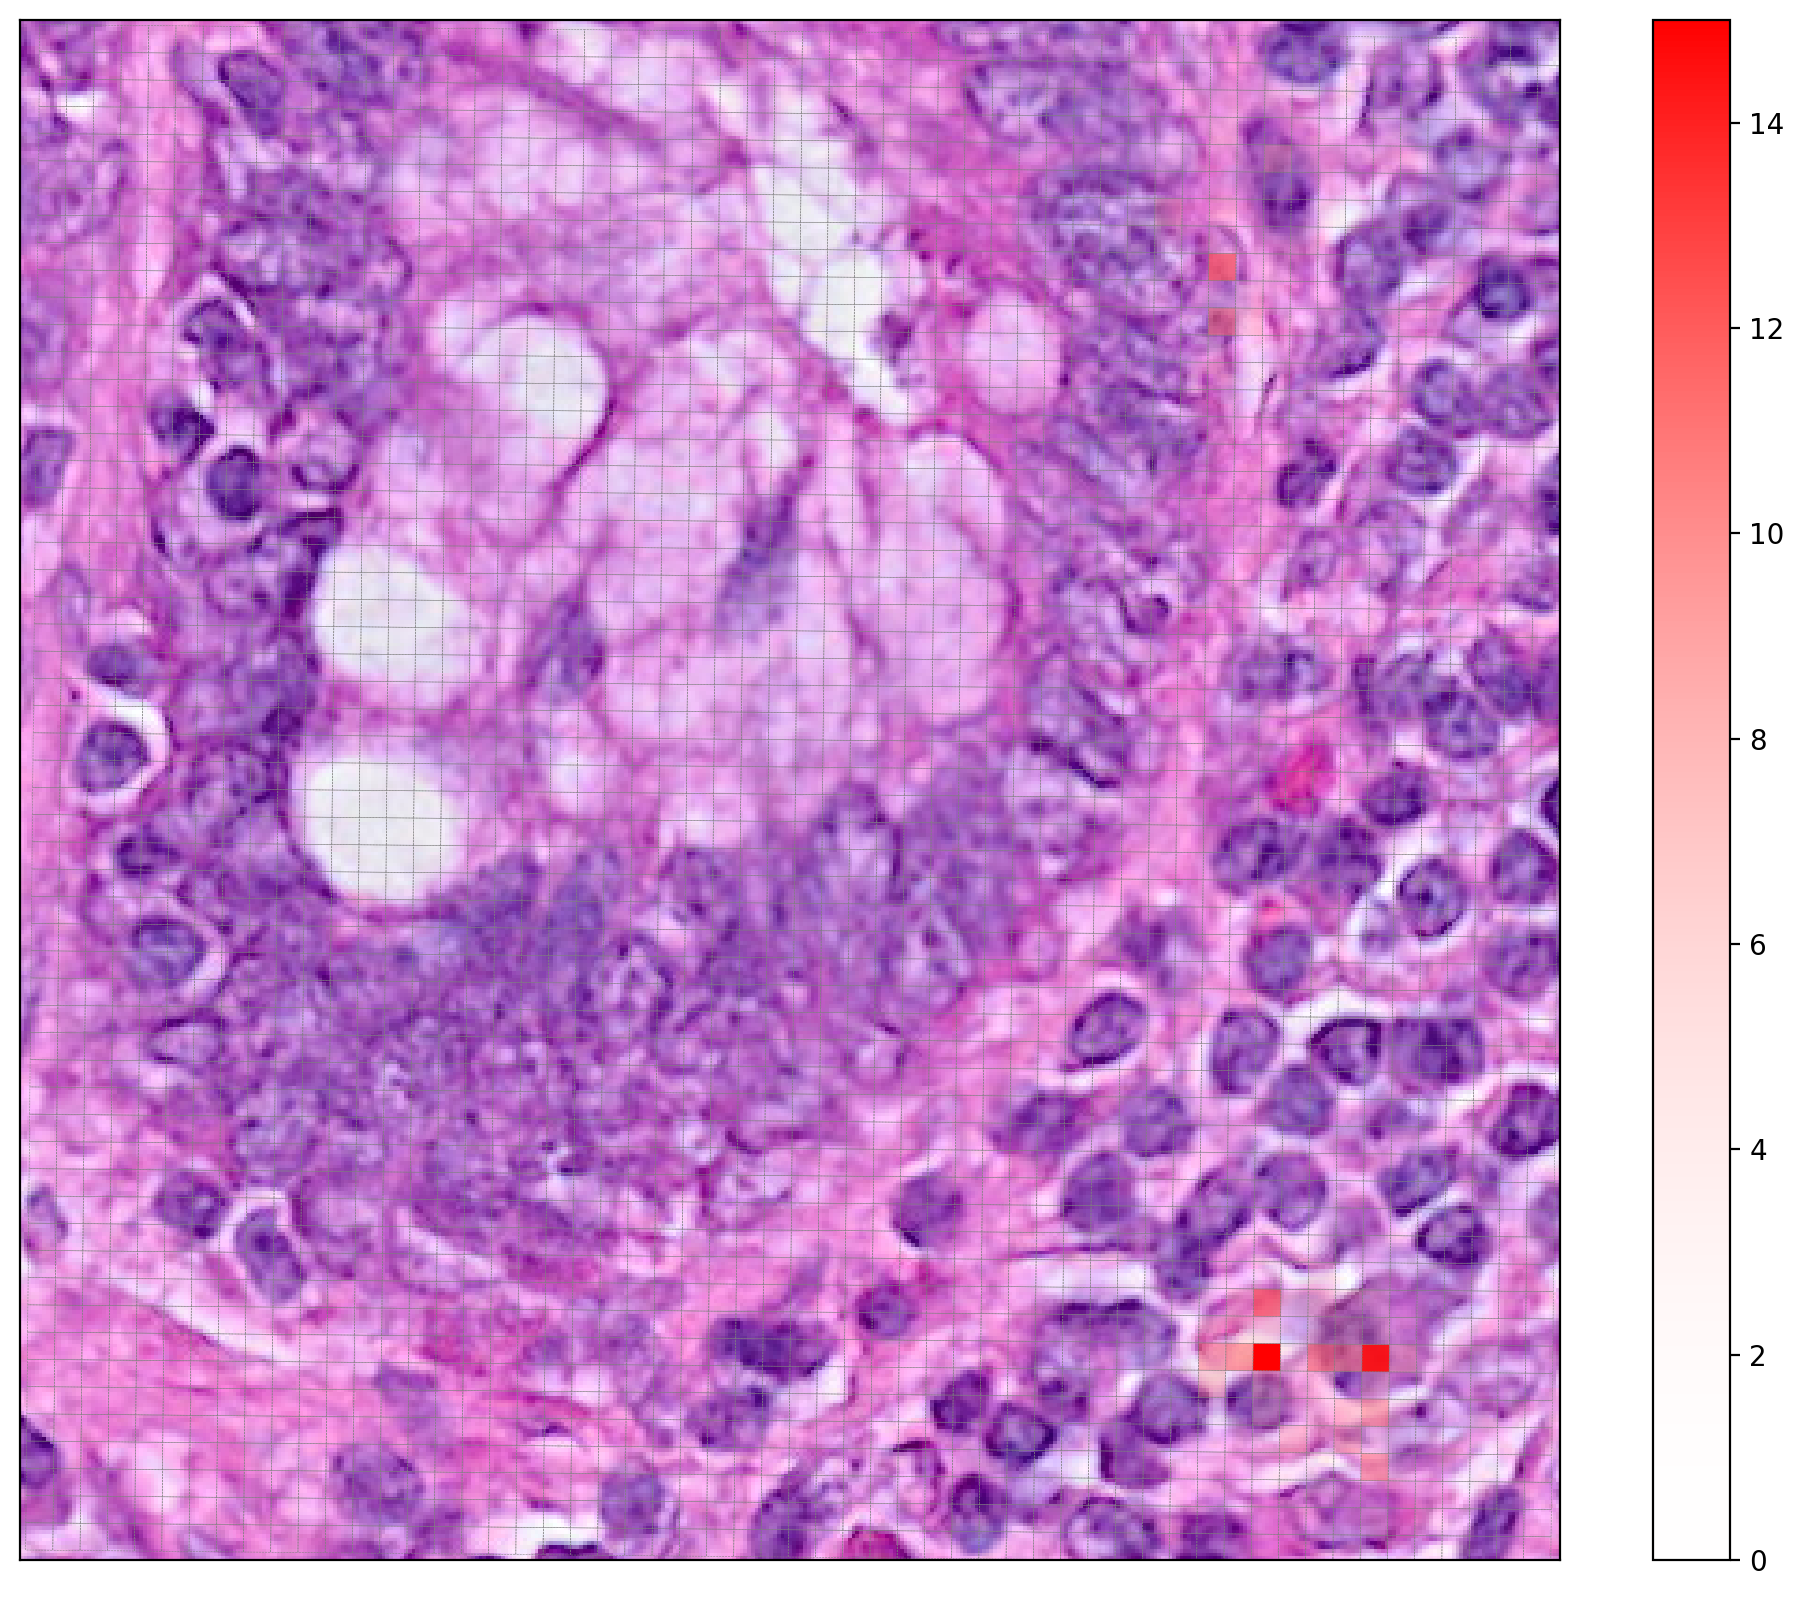

In [312]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_patch_with_cropped_HE(ax, HE_img, selected_ROI, adata_subset_05, gene='IGHG1')
plt.savefig(f'binX_{x_hd_2}_binY_{y_hd_2}_224_IGHG1_HE_raw.pdf', format='pdf', bbox_inches='tight')
plt.show()

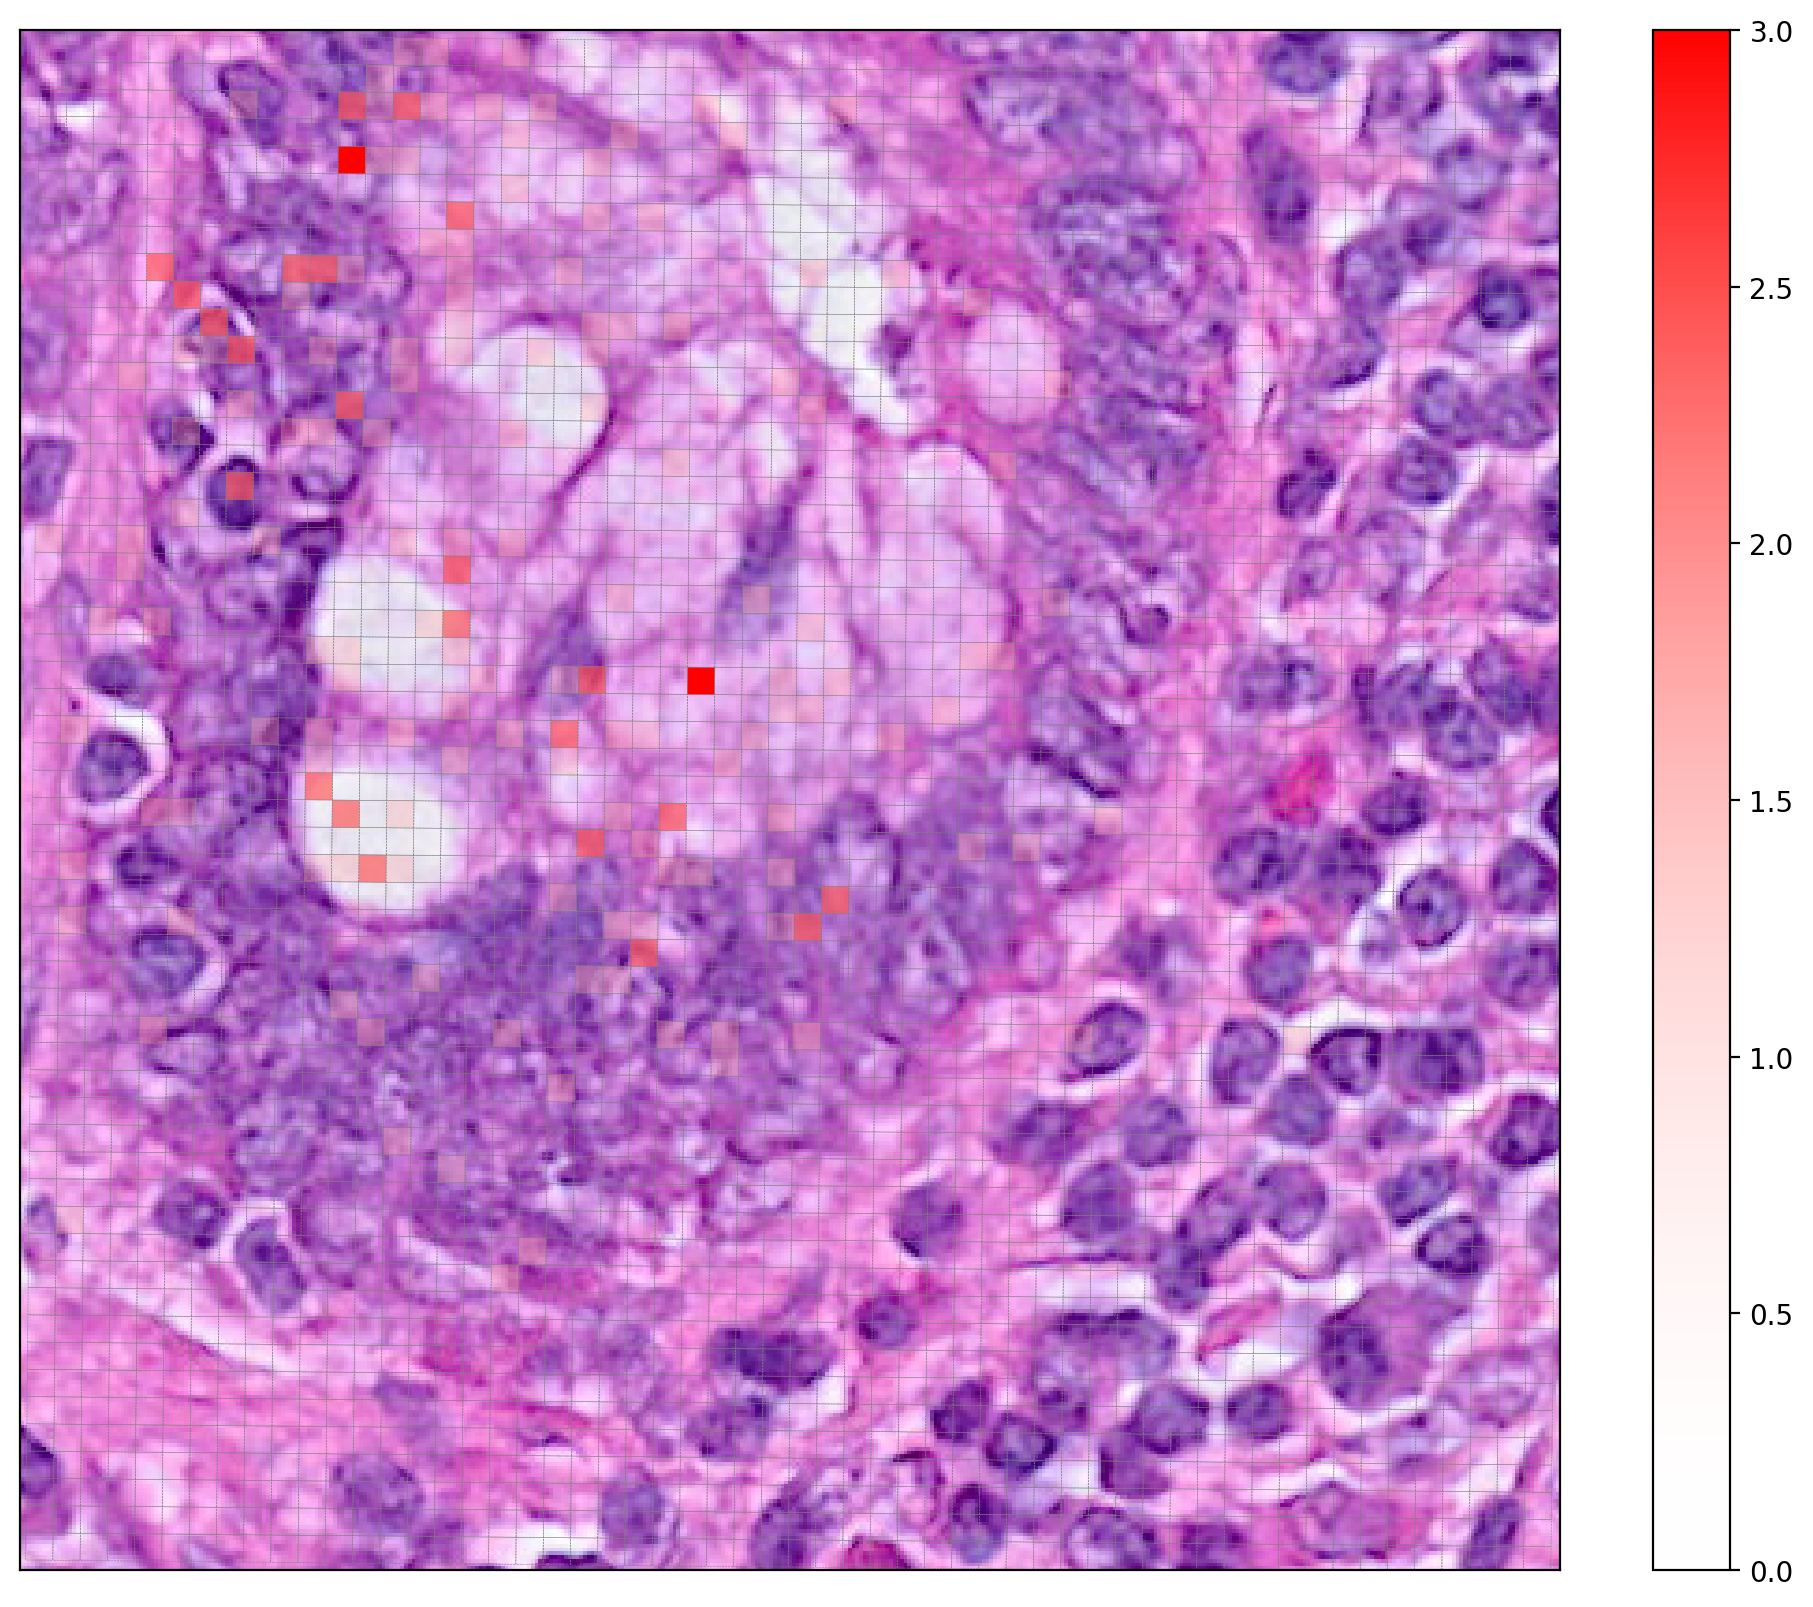

In [313]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_patch_with_cropped_HE(ax, HE_img, selected_ROI, adata_subset_05, gene='MUC2')
plt.savefig(f'binX_{x_hd_2}_binY_{y_hd_2}_224_MUC2_HE_raw.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [314]:
selected_ROI = raw_patch[raw_patch.index.isin(adata_subset_05_CELL.obs.index)]
x_cols = [col for col in selected_ROI.columns if '_px_fr' in col]
y_cols = [col for col in selected_ROI.columns if '_py_fr' in col]

all_x = selected_ROI[x_cols].values.flatten()
all_y = selected_ROI[y_cols].values.flatten()

x_max = all_x.max()
x_min = all_x.min()
y_max = all_y.max()
y_min = all_y.min()

In [317]:
selected_ROI

spot_x  spot_y  in_tissue   pxl_x   pxl_y  tl_pxl_x  \
barcode                                                                      
s_002um_01205_01508-1    1508    1205          1  1508.5  2154.5    1508.0   
s_002um_01205_01509-1    1509    1205          1  1509.5  2154.5    1509.0   
s_002um_01205_01510-1    1510    1205          1  1510.5  2154.5    1510.0   
s_002um_01205_01511-1    1511    1205          1  1511.5  2154.5    1511.0   
s_002um_01205_01512-1    1512    1205          1  1512.5  2154.5    1512.0   
...                       ...     ...        ...     ...     ...       ...   
s_002um_01212_01511-1    1511    1212          1  1511.5  2147.5    1511.0   
s_002um_01212_01512-1    1512    1212          1  1512.5  2147.5    1512.0   
s_002um_01212_01513-1    1513    1212          1  1513.5  2147.5    1513.0   
s_002um_01212_01514-1    1514    1212          1  1514.5  2147.5    1514.0   
s_002um_01212_01515-1    1515    1212          1  1515.5  2147.5    1515.0   

                       tl_pxl_y  corner_1_px_fr  corner_1_py_fr  \
barcode                                                           
s_002um_01205_01508-1    2154.0    10839.327150    27905.391850   
s_002um_01205_01509-1    2154.0    10846.631244    27905.459276   
s_002um_01205_01510-1    2154.0    10853.935338    27905.526701   
s_002um_01205_01511-1    2154.0    10861.239432    27905.594127   
s_002um_01205_01512-1    2154.0    10868.543527    27905.661552   
...                         ...             ...             ...   
s_002um_01212_01511-1    2147.0    10861.716097    27854.457404   
s_002um_01212_01512-1    2147.0    10869.020192    27854.524828   
s_002um_01212_01513-1    2147.0    10876.324288    27854.592253   
s_002um_01212_01514-1    2147.0    10883.628383    27854.659678   
s_002um_01212_01515-1    2147.0    10890.932480    27854.727102   

                       corner_2_px_fr  corner_2_py_fr  corner_3_px_fr  \
barcode                                                                 
s_002um_01205_01508-1    10839.395244    27898.086605    10846.631244   
s_002um_01205_01509-1    10846.699338    27898.154030    10853.935338   
s_002um_01205_01510-1    10854.003433    27898.221456    10861.239432   
s_002um_01205_01511-1    10861.307527    27898.288881    10868.543527   
s_002um_01205_01512-1    10868.611622    27898.356307    10875.847622   
...                               ...             ...             ...   
s_002um_01212_01511-1    10861.784192    27847.152157    10869.020192   
s_002um_01212_01512-1    10869.088287    27847.219582    10876.324288   
s_002um_01212_01513-1    10876.392383    27847.287006    10883.628383   
s_002um_01212_01514-1    10883.696479    27847.354430    10890.932480   
s_002um_01212_01515-1    10891.000575    27847.421855    10898.236576   

                       corner_3_py_fr  corner_4_px_fr  corner_4_py_fr  
barcode                                                                
s_002um_01205_01508-1    27905.459276    10846.699338    27898.154030  
s_002um_01205_01509-1    27905.526701    10854.003433    27898.221456  
s_002um_01205_01510-1    27905.594127    10861.307527    27898.288881  
s_002um_01205_01511-1    27905.661552    10868.611622    27898.356307  
s_002um_01205_01512-1    27905.728978    10875.915717    27898.423732  
...                               ...             ...             ...  
s_002um_01212_01511-1    27854.524828    10869.088287    27847.219582  
s_002um_01212_01512-1    27854.592253    10876.392383    27847.287006  
s_002um_01212_01513-1    27854.659678    10883.696479    27847.354430  
s_002um_01212_01514-1    27854.727102    10891.000575    27847.421855  
s_002um_01212_01515-1    27854.794527    10898.304671    27847.489279  

[64 rows x 15 columns]

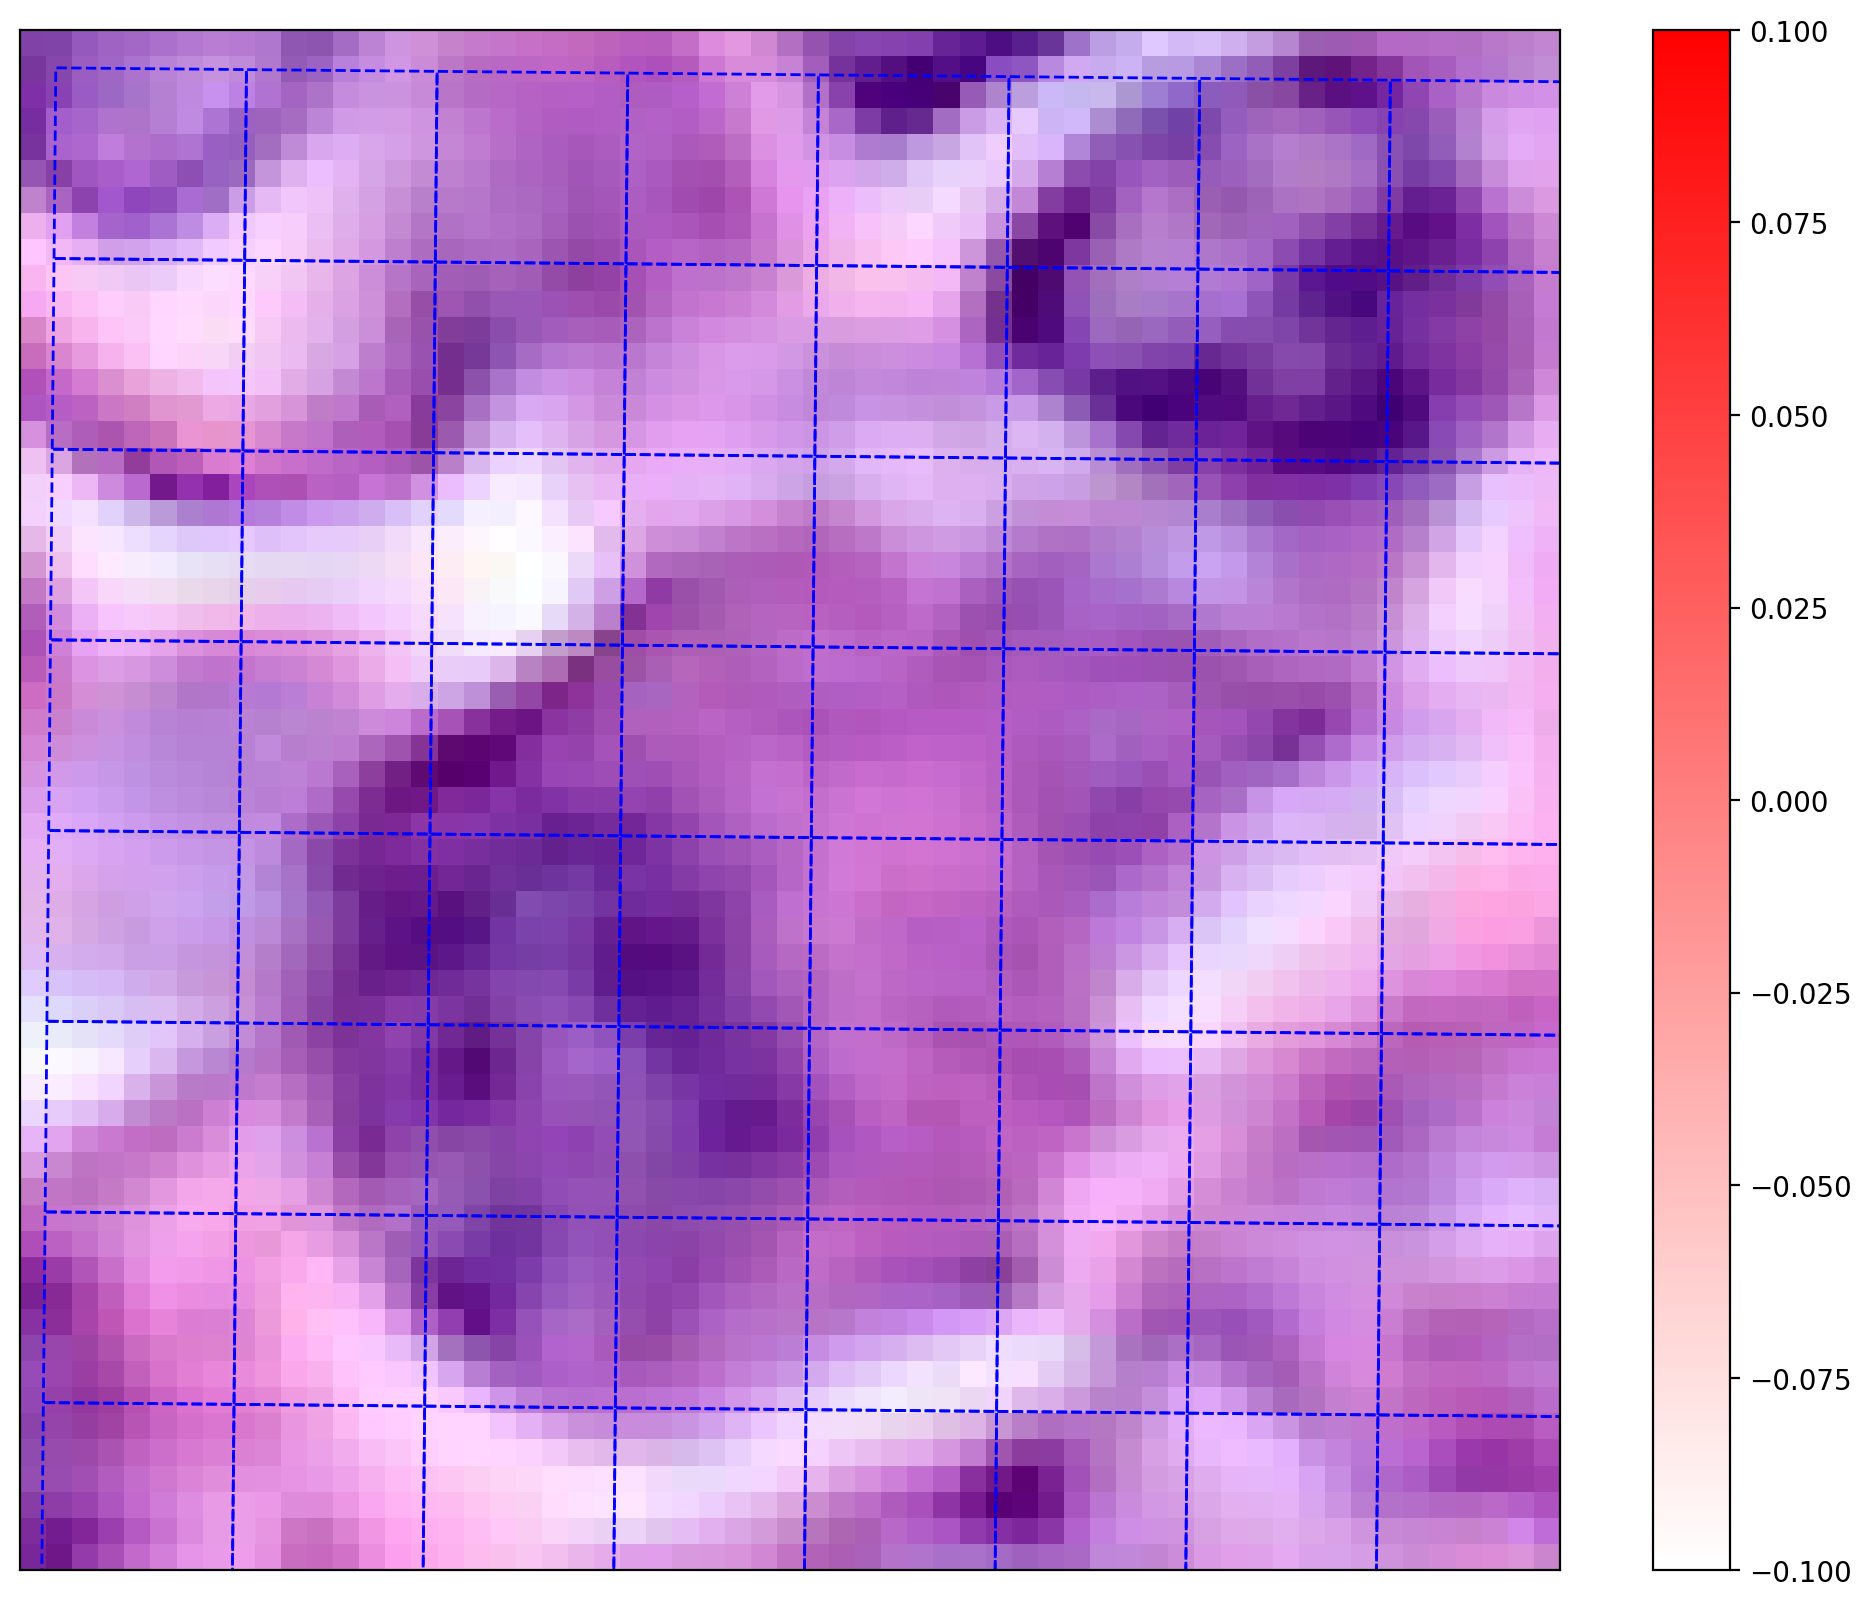

In [336]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_patch_with_cropped_HE(ax, HE_img, selected_ROI, adata_subset_1_CELL, gene='CD8A')
plt.savefig(f'./fig/binX_{x_hd_2}_binY_{y_hd_2}_224_CD8A_CELL_raw.pdf', format='pdf', bbox_inches='tight')
plt.show()

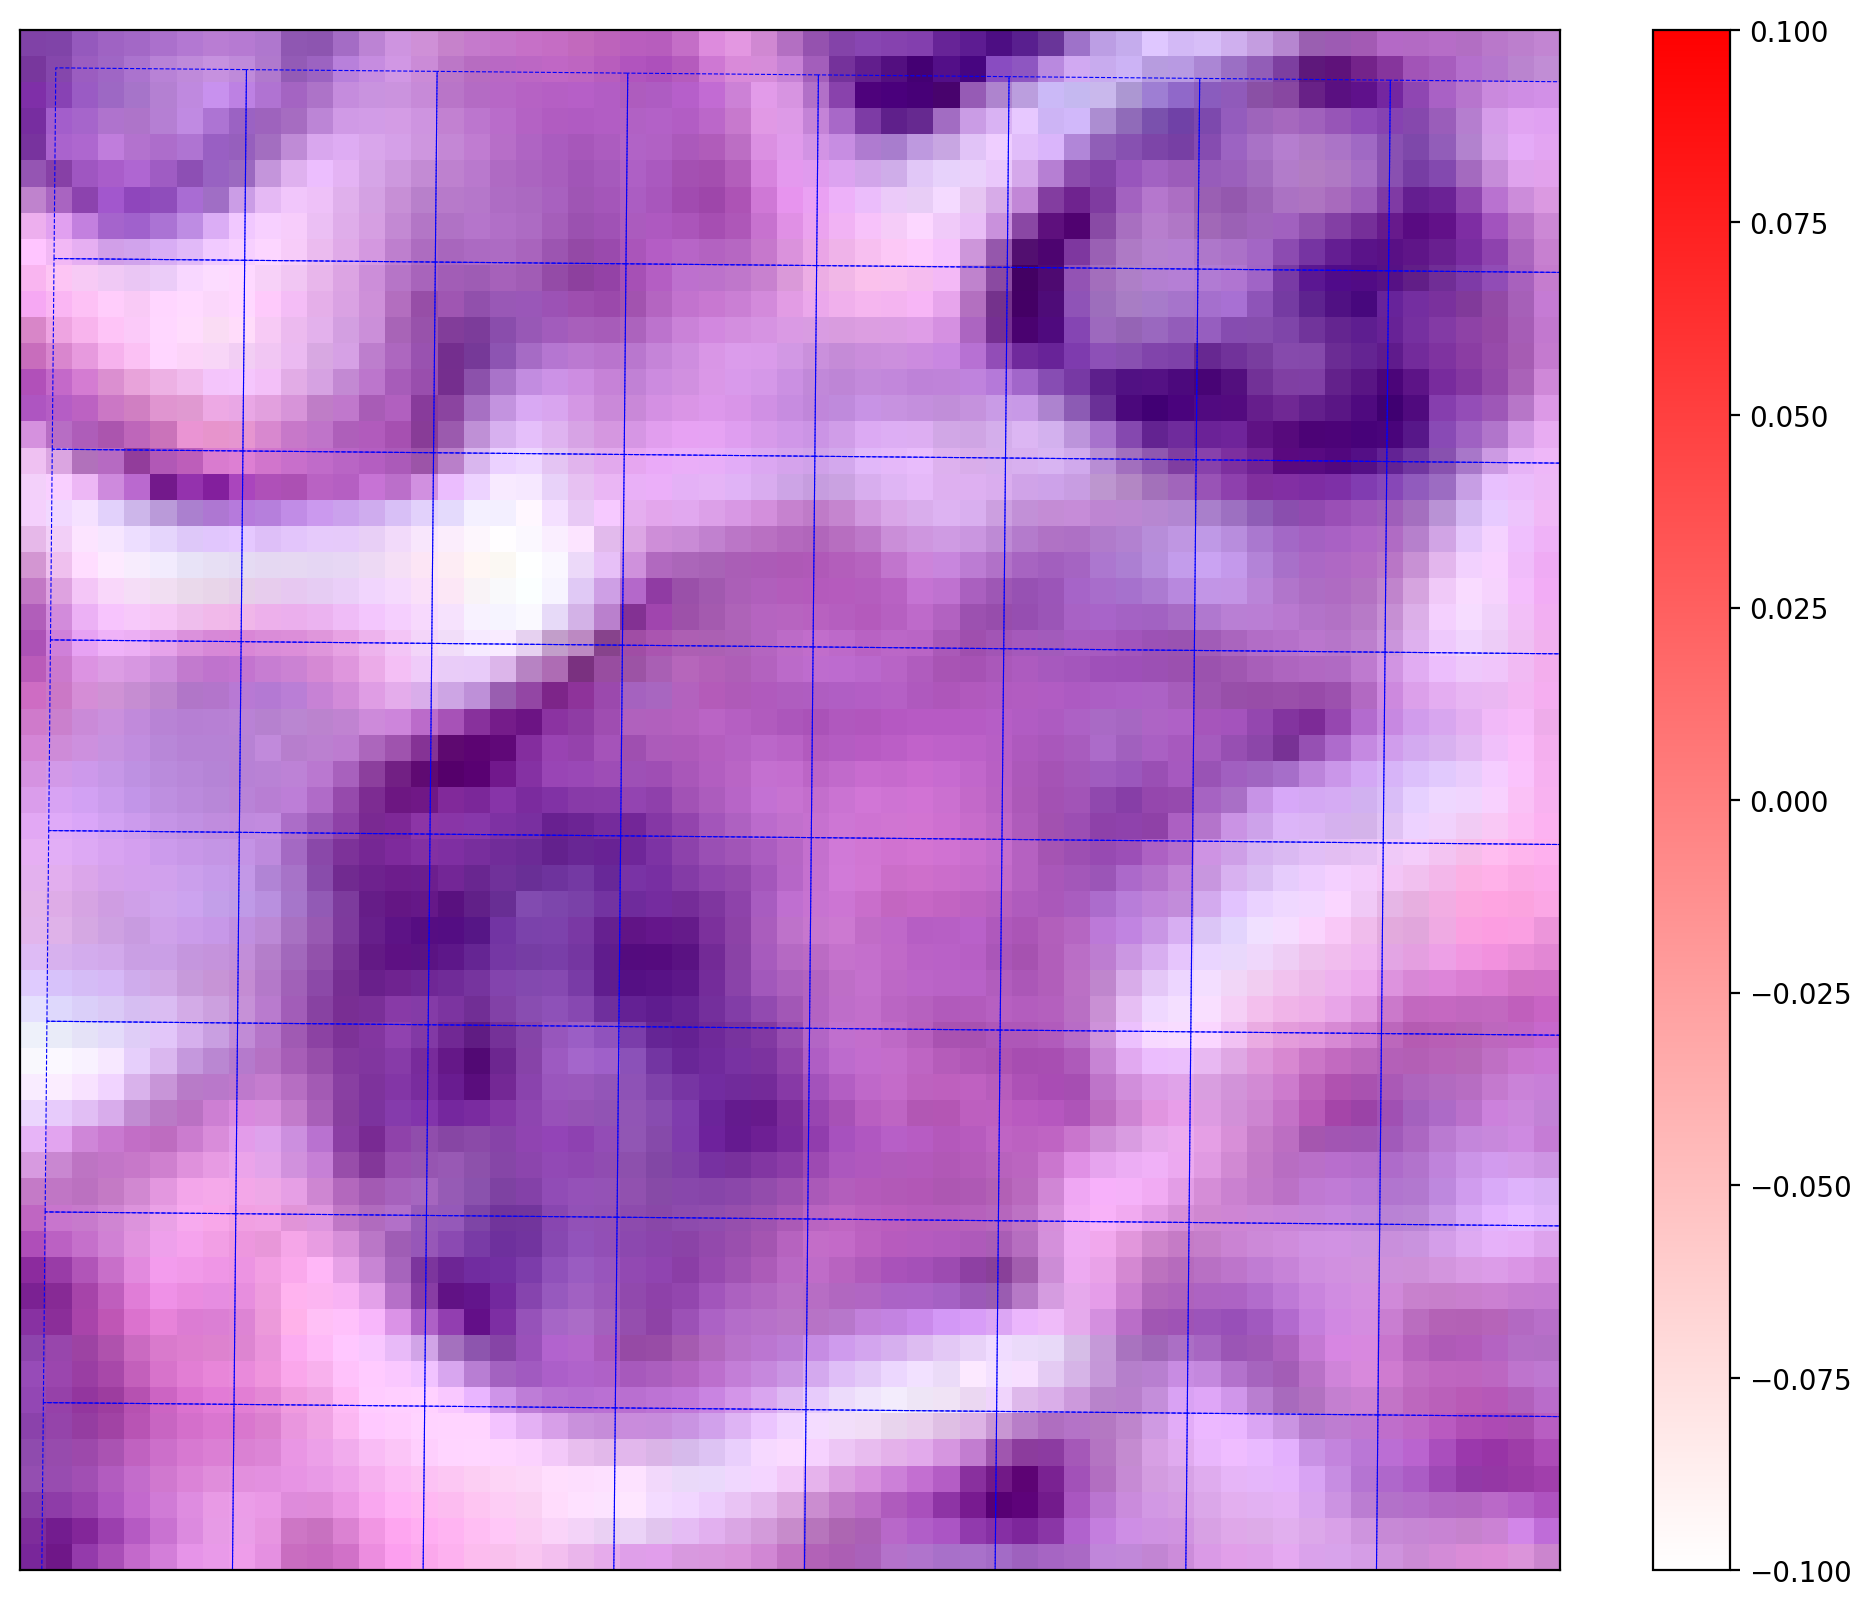

In [323]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_patch_with_cropped_HE(ax, HE_img, selected_ROI, adata_subset_1_CELL, gene='CD8A')
plt.savefig(f'binX_{x_hd_2}_binY_{y_hd_2}_224_CELL_raw.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### useless

In [ ]:
import numpy as np



def _affine_trans(x, y, matrix=affine_matrix):
    """
    Apply a 2D affine transform to a point (x, y).
    
    Returns:
        (x', y'): Transformed coordinates as a tuple.
    """
    coord = np.array([x, y, 1])
    transformed = matrix @ coord
    return tuple(transformed)

x_prime, y_prime = _affine_trans(1486, 1232)
print(f"(1486, 1232) → ({x_prime}, {y_prime})")  